## Uplift-моделирование

### Домашнее задание.

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [1]:
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier

In [2]:
FILE_DATA = 'HW_data.csv'
df = pd.read_csv(FILE_DATA)

In [3]:
df.rename(columns={"offer": "treatment", "conversion": "target"}, inplace=True)
df['treatment'] = np.where(df['treatment'] == 'No Offer', 0, 1)
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,1,0
63996,5,38.91,0,1,Urban,1,Phone,1,0
63997,6,29.99,1,0,Urban,1,Phone,1,0
63998,1,552.94,1,0,Surburban,1,Multichannel,1,0


Посмотрим на распределения treatment и target. Сделаем разбиение на обучающую и валидационную выборку, используя стратификацию сразу по двум столбцам - treatment и target.

In [4]:
print(df.treatment.sum() / df.treatment.count())
print(df.target.sum() / df.target.count())

0.66709375
0.14678125


In [5]:
cat_features = ['zip_code', 'channel']
others_futures = ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral']

In [6]:
X_train, X_valid, y_train, y_valid, treat_train, treat_valid = train_test_split(df[cat_features + others_futures],
                                                                                df['target'],
                                                                                df['treatment'],
                                                                                stratify=df[['treatment', 'target']],
                                                                                test_size=0.3, random_state=123)

In [7]:
print(treat_train.sum() / treat_train.count())
print(y_train.sum() / y_train.count())

0.6670982142857143
0.14676339285714285


In [8]:
print(treat_valid.sum() / treat_valid.count())
print(y_valid.sum() / y_valid.count())

0.6670833333333334
0.14682291666666666


Как видно, train_test_split хорошо разбил нашу выборку.

In [9]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

In [10]:
df[cat_features].value_counts() # Для one_hot_max_size

zip_code   channel     
Surburban  Web             12790
           Phone           12521
Urban      Phone           11305
           Web             11189
Rural      Web              4238
           Phone            4195
Surburban  Multichannel     3465
Urban      Multichannel     3167
Rural      Multichannel     1130
dtype: int64

In [11]:
disbalance = y_train.sum() / y_train.count()

frozen_params = {
     'thread_count': 2, 
     'random_state': 42, 
     'silent': True,
     'class_weights': [1, disbalance], 
     'one_hot_max_size': 3,
     'cat_features': cat_features
}

uplift@10%: 0.0911
uplift@20%: 0.0750


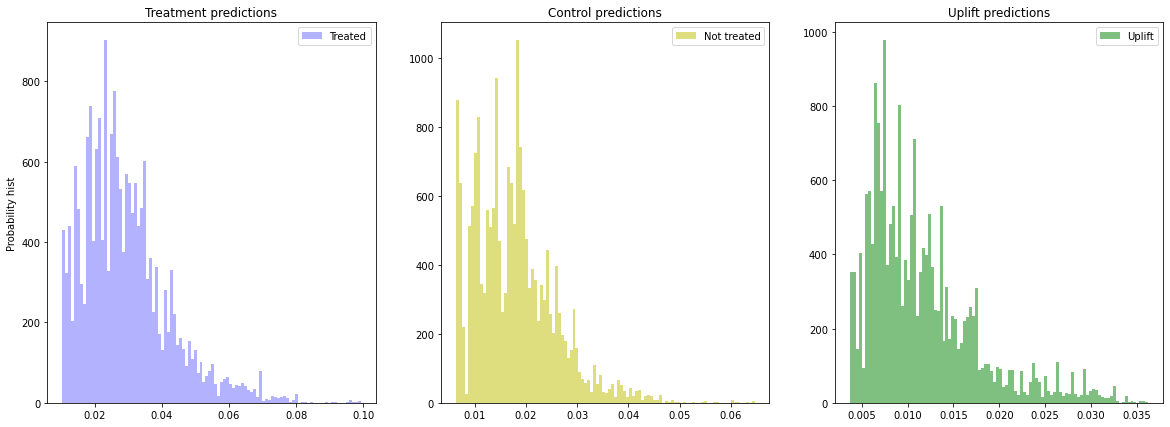

In [12]:
sm = SoloModel(CatBoostClassifier(**frozen_params, iterations=20, max_depth=3))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_valid)

sm_score_10 = uplift_at_k(y_true=y_valid, uplift=uplift_sm, treatment=treat_valid, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_valid, uplift=uplift_sm, treatment=treat_valid, strategy='by_group', k=0.2)
print(f'uplift@10%: {sm_score_10:.4f}')
print(f'uplift@20%: {sm_score_20:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [13]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,19.181927
1,treatment,18.276610
2,used_bogo,17.293241
3,recency,13.452347
4,used_discount,10.409574
5,history,9.604288
6,zip_code,6.135254
7,channel,5.646760


In [14]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(**frozen_params, iterations=50, max_depth=5))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_valid)

ct_score_10 = uplift_at_k(y_true=y_valid, uplift=uplift_ct, treatment=treat_valid, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_valid, uplift=uplift_ct, treatment=treat_valid, strategy='by_group', k=0.2)
print(f'uplift@10%: {ct_score_10:.4f}')
print(f'uplift@20%: {ct_score_20:.4f}')

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

uplift@10%: 0.0865
uplift@20%: 0.0747


In [15]:
ct_fi = pd.DataFrame({
    'feature_name': ct.estimator.feature_names_,
    'feature_score': ct.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

ct_fi

,feature_name,feature_score
0,history,35.459735
1,recency,21.058401
2,zip_code,12.023903
3,channel,9.984051
4,is_referral,7.970891
5,used_bogo,7.875429
6,used_discount,5.627590


uplift@10%: 0.0865
uplift@20%: 0.0708


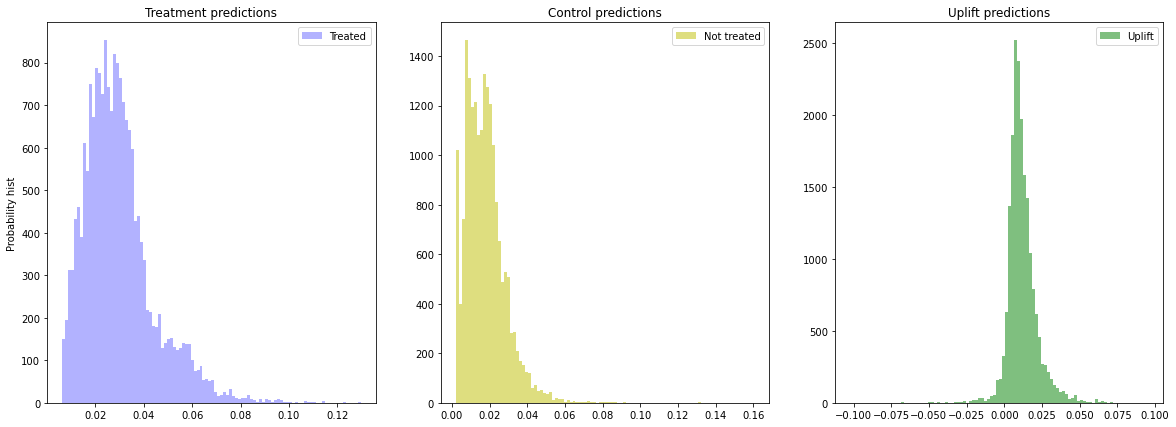

In [16]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(**frozen_params, iterations=20, max_depth=8), 
    estimator_ctrl=CatBoostClassifier(**frozen_params, iterations=20, max_depth=8), 
    method='vanilla'
)
tm = tm.fit(X_train, y_train, treat_train,)

uplift_tm = tm.predict(X_valid)

tm_score_10 = uplift_at_k(y_true=y_valid, uplift=uplift_tm, treatment=treat_valid, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_valid, uplift=uplift_tm, treatment=treat_valid, strategy='by_group', k=0.2)
print(f'uplift@10%: {tm_score_10:.4f}')
print(f'uplift@20%: {tm_score_20:.4f}')

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [17]:
pd.DataFrame(data=models_results)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.091103,0.075019
1,ClassTransformation,0.086467,0.074682
2,TwoModels,0.086477,0.070783


Видно, что на данной задаче лучше всего себя показала SoloModel

In [18]:
uplift_sm_perc = pd.DataFrame({'uplift_sm': uplift_sm,
                         'target': y_valid}).reset_index(drop=True)
uplift_sm_perc

,uplift_sm,target
0,0.015181,0
1,0.017884,0
2,0.008524,0
3,0.006627,1
4,0.006572,0
...,...,...
19195,0.023386,0
19196,0.006912,0
19197,0.023641,0
19198,0.013022,0


In [19]:
uplift_sm_perc.sort_values('uplift_sm', ascending=False, inplace=True)
uplift_sm_perc

,uplift_sm,target
13938,0.036258,1
1433,0.035829,0
984,0.035829,1
3687,0.035772,1
9771,0.035772,1
...,...,...
2352,0.003766,0
11336,0.003766,0
18654,0.003742,0
14656,0.003742,0


In [20]:
uplift_sm_perc['decilies'] =  pd.qcut(uplift_sm_perc['uplift_sm'], 10, labels=False)
uplift_sm_perc

,uplift_sm,target,decilies
13938,0.036258,1,9
1433,0.035829,0,9
984,0.035829,1,9
3687,0.035772,1,9
9771,0.035772,1,9
...,...,...,...
2352,0.003766,0,0
11336,0.003766,0,0
18654,0.003742,0,0
14656,0.003742,0,0


In [21]:
uplift_sm_perc.groupby(uplift_sm_perc['decilies']).agg({'target': 'mean'}).rename(columns={'target': 'mean_conversation'})

,mean_conversation
decilies,
0,0.068714
1,0.098069
2,0.118325
3,0.125786
4,0.129338
5,0.153730
6,0.171152
7,0.151594
8,0.196242


Как видно, от модели действительно есть польза - практически для каждого дециля значения uplift, конверсия следующего дециля больше предыдущего